In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import pandas as pd
import copy
import swifter
import matplotlib.pyplot as plt
from methylation_utils.methylation_utils.analyzer import MethylationAnalyzerHelper
from methylation_utils.methylation_utils.plot import MethPlot
import pyarrow.feather as feather

In [16]:
BOTTOM_SAMPLES = "data/old_data/bottom/01_process.py.samples"
ADENOMA_F_SAMPLES = "data/old_data/adenoma_female/01_process.py.samples"
ADENOMA_M_SAMPLES = "data/old_data/adenoma_male/01_process.py.samples"
LEUKENMIAS_SAMPLES = "data/old_data/leukemias/01_process.py.samples"
MIDDLE_SAMPLES = "data/old_data/middle/01_process.py.samples"
ALL_SAMPLES_FILE = "data/old_data/runAll.sh.samples"

SAMPLE_FILES = [
    BOTTOM_SAMPLES,
    ADENOMA_F_SAMPLES,
    ADENOMA_M_SAMPLES,
    LEUKENMIAS_SAMPLES,
    MIDDLE_SAMPLES,
]

METH_DYNAMIC_FOLDER = "data/old_data/bottom/samples_meth_dynamic"
METH_REF_FILE = "data/old_data/parse450K.pl.order.lookup"

In [17]:
""" Read in the sample info and methylation reference into memory """
meth_ref = pd.read_csv(METH_REF_FILE, sep="\t")

In [18]:
DEBUG = False

""" For individual samples """
METH_INTERMEDIATE_HIGH_CUTOFF = 70
METH_INTERMEDIATE_LOW_CUTOFF = 20

# Percent of markers that need to be intermediatly methylated in a window
CUTOFF_PCT = 0.60


LENGTH_CUTTOFF = 1000
COUNT_CUTTOFF = 50
COVERAGE_CUTOFF = 0.75

In [19]:
windows_to_analyze = feather.read_feather("shared_data/windows_to_analyze.cancer.feather")

In [33]:
windows_to_analyze["coverage_percentage"] = windows_to_analyze["coverage_percentage"].astype(float)
windows_to_analyze.sort_values(['chrom_num', 'start'], inplace=True)
windows_to_analyze.reset_index(drop=True, inplace=True)

In [34]:
tsv_copy = windows_to_analyze.copy()
tsv_copy = tsv_copy[['chrom', 'start', 'end']]

In [35]:
tsv_copy["region"] = tsv_copy.apply(lambda x: f"region_{x.name}", axis=1)
tsv_copy

,chrom,start,end,region
0,chr1,910429,924641,region_0
1,chr1,3024260,3084437,region_1
2,chr1,3533662,3579462,region_2
3,chr1,18684521,18875365,region_3
4,chr1,24931074,25067262,region_4
...,...,...,...,...
93,chr20,63025520,63187054,region_93
94,chr20,63534241,63553009,region_94
95,chr22,46074310,46147348,region_95
96,chr22,49091530,49488034,region_96


In [36]:
tsv_copy.to_csv("shared_data/windows_to_analyze.cancer.tsv", index=False, header=False, sep="\t")

In [18]:
def get_variable_name(var):
    # Iterate over the global variables
    for name, value in globals().items():
        if value is var:
            return name
    return None

In [19]:
def windows_statistics(windows, graph_only=False):
    print("__________________INTERMEDIATE PERCENT STATISTICS__________________")
    windows["intermediate_percent"].hist(bins=100)

    plt.title("Percent Intermediate Methylation In Region")
    plt.xlabel("Percent Intermediate Methylated")
    plt.ylabel("Number of Regions")
    plt.show()
    if graph_only:
        return
    print(
        windows["intermediate_percent"]
        .describe()
        .apply(lambda x: "{:,.2f}".format(x)))


In [20]:
get_variable_name(SAMPLE_FILES[0]).replace("_", " ").title()

'Bottom Samples'

In [21]:
bottom_sample_info = pd.read_csv(SAMPLE_FILES[0], sep="\t")
adenoma_f_sample_info = pd.read_csv(SAMPLE_FILES[1], sep="\t")

In [22]:
bottom_sample_info

,sample,expression,expression_file,methylation,methylation_file,sample_id,project_id,composition,sample_type,tissue_type,tumor_descriptor,project_descriptor
0,TCGA-VS-A9V0-01A,f37f2d34-cf48-41e4-89a5-3193ac34d7b3.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,c12f254d-796c-4a34-9892-6e7b01686dd5.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,07a9ae9e-fce3-4975-8726-a3b5e9c2ff71,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
1,TCGA-VS-A9UP-01A,2d70ee13-be72-4c82-8f66-98255b4d9e04.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,4985905e-febc-4d53-a9b0-de157e81e1eb.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,04b8f6aa-7f97-4d01-a890-d9e6aa1d45df,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
2,TCGA-Q1-A6DV-01A,d1161c1c-a87f-4c08-8c98-554d7411655e.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,185aac61-6d67-4d03-a4eb-74b71fee3024.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,f717f1ad-0582-47e3-a337-c39e0d837f4d,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
3,TCGA-DS-A7WF-01A,2539187f-6898-4e7c-ab83-4ea32d55e036.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,08b8bdc0-fb6f-41f0-b821-8c9088d65c3c.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,14c03e34-5e97-42f5-9789-2a92fb8bbcf3,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
4,TCGA-VS-A9UT-01A,af032dc7-51da-46c9-98af-733695b1ddf3.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,fba06680-548b-4a2c-8277-cc83107a03a1.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,c772bc85-f358-450a-8693-899eac419271,TCGA-CESC,Not Reported,Primary Tumor,Not Reported,Not Reported,Cervical squamous cell carcinoma and endocervi...
...,...,...,...,...,...,...,...,...,...,...,...,...
2581,TCGA-D1-A3JP-01A,0a3d9bab-7802-4ae9-8ab2-56baa97563d9.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,096cb90c-b49e-4a14-8143-0936f1791d40.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,29a581ed-3dca-4a65-ab6b-5a9656674f92,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma
2582,TCGA-D1-A1NW-01A,822150f4-4085-40be-a6c2-610e2a151c28.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,c6cb50ee-1824-4184-a7dd-90e12da0d8e1.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,b79a1d9c-02ef-4192-beb3-bca8b362eb2e,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma
2583,TCGA-AX-A3G6-01A,368effd8-38b4-48f8-8405-642bc28900b6.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,516a6ea7-2b9d-415e-8bab-34ad62f22e57.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,576ab148-2110-4f35-948a-4a0d00b4f48e,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma
2584,TCGA-B5-A5OD-01A,de0ac7a9-1056-4422-b428-c79181273c66.rna_seq.a...,/uufs/chpc.utah.edu/common/home/clementm-group...,00a59d36-e460-4ee9-b80f-60d4d6748b08.methylati...,/uufs/chpc.utah.edu/common/home/clementm-group...,71994580-4a7f-433d-80d3-71e408d44eb3,TCGA-UCEC,Not Reported,Primary Tumor,Not Reported,Not Reported,Uterine Corpus Endometrial Carcinoma


In [23]:
if "intermediate_percent_all" in windows_to_analyze.columns:
    windows_to_analyze["intermediate_percent"] = windows_to_analyze[
        "intermediate_percent_all"
    ]
windows_to_analyze["intermediate_percent_all"] = windows_to_analyze[
    "intermediate_percent"
]
windows_to_analyze.drop(columns=["intermediate_percent"], inplace=True)
meth_ref_sorted_dict = {}
window_df_dict = {}
for sample in SAMPLE_FILES:
    sample_sample_info = pd.read_csv(sample, sep="\t")
    sample_cutoff_val = len(sample_sample_info.index) / 2
    sample_helper = MethylationAnalyzerHelper(
        upper_cutoff=METH_INTERMEDIATE_HIGH_CUTOFF,
        lower_cutoff=METH_INTERMEDIATE_LOW_CUTOFF,
        dmr_percent_cutoff=CUTOFF_PCT,
        sample_cutoff_val=sample_cutoff_val,
        debug=DEBUG,
        optimize_for_humans=False,
    )
    sample_meth_ref_sorted = sample_helper.populate_intertmediate_methylation_data(
        sample_sample_info,
        meth_ref,
        supress_prints=True,
    )
    meth_ref_sorted_dict[get_variable_name(sample)] = sample_meth_ref_sorted
    sample_window_data = copy.deepcopy(windows_to_analyze)
    sample_window_data = sample_helper.populate_region_stats(
        sample_window_data, sample_meth_ref_sorted
    )
    window_df_dict[get_variable_name(sample)] = sample_window_data


IntProgress(value=0, max=2586)

IntProgress(value=0, max=145)

IntProgress(value=0, max=1769)

IntProgress(value=0, max=145)

IntProgress(value=0, max=2222)

IntProgress(value=0, max=145)

IntProgress(value=0, max=271)

IntProgress(value=0, max=145)

IntProgress(value=0, max=2866)

IntProgress(value=0, max=145)

In [24]:
for key, value in meth_ref_sorted_dict.items():
    print(key, value["intermediate_count"].mean())

BOTTOM_SAMPLES 614.1046878421006
ADENOMA_F_SAMPLES 420.6839742313671
ADENOMA_M_SAMPLES 532.773274431724
LEUKENMIAS_SAMPLES 36.75827924228375
MIDDLE_SAMPLES 748.2119972580768


In [25]:
for key, value in window_df_dict.items():
    windows_to_analyze[f"intermediate_percent_{key.lower()}"] = value["intermediate_percent"]

In [26]:
windows_to_analyze[
    (
        windows_to_analyze["intermediate_percent_all"]
        < windows_to_analyze["intermediate_percent_bottom_samples"]
    )
    | (
        windows_to_analyze["intermediate_percent_all"]
        < windows_to_analyze["intermediate_percent_adenoma_f_samples"]
    )
    | (
        windows_to_analyze["intermediate_percent_all"]
        < windows_to_analyze["intermediate_percent_adenoma_m_samples"]
    )
    | (
        windows_to_analyze["intermediate_percent_all"]
        < windows_to_analyze["intermediate_percent_leukenmias_samples"]
    )
    | (
        windows_to_analyze["intermediate_percent_all"]
        < windows_to_analyze["intermediate_percent_middle_samples"]
    )
]

,index,chrom,start,end,length,CpG_chrm,chrom_num,count_in_window,coverage_percentage,dist_to_next,intermediate_percent_all,intermediate_percent_bottom_samples,intermediate_percent_adenoma_f_samples,intermediate_percent_adenoma_m_samples,intermediate_percent_leukenmias_samples,intermediate_percent_middle_samples
0,3,chr1,910429,924641,14212,chr1,1,23,0.972108,56841.0,0.625000,0.633333,0.533333,0.615385,0.176471,0.531250
2,115,chr1,2413558,2442415,28857,chr1,1,21,0.908837,187199.0,0.636364,0.785714,0.642857,0.653846,0.205882,0.535714
3,132,chr1,2629614,2876138,246524,chr1,1,49,0.864880,46101.0,0.620000,0.630137,0.493151,0.523810,0.107527,0.583333
5,145,chr1,3024260,3084437,60177,chr1,1,40,0.908291,55150.0,0.634146,0.576271,0.472727,0.614035,0.164384,0.671875
7,441,chr1,17245400,17406231,160831,chr1,1,23,0.886419,1278290.0,0.625000,0.656250,0.558824,0.592593,0.230769,0.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,15080,chr7,94656359,95396898,740539,chr7,7,68,0.938700,1592857.0,0.623188,0.494949,0.561224,0.677419,0.466102,0.593407
134,15084,chr7,96989755,97732446,742691,chr7,7,57,0.904311,32758193.0,0.655172,0.305882,0.428571,0.607595,0.330357,0.731707
137,15890,chr8,54457868,55523833,1065965,chr8,8,26,0.844742,43423540.0,0.629630,0.454545,0.326087,0.533333,0.200000,0.642857
140,16180,chr8,142089906,142252156,162250,chr8,8,41,0.857177,931260.0,0.642857,0.763636,0.603448,0.574074,0.084507,0.611111


In [27]:
windows_to_analyze[
    ["intermediate_percent_all"]
    + [f"intermediate_percent_{key.lower()}" for key in window_df_dict.keys()]
].describe()

,intermediate_percent_all,intermediate_percent_bottom_samples,intermediate_percent_adenoma_f_samples,intermediate_percent_adenoma_m_samples,intermediate_percent_leukenmias_samples,intermediate_percent_middle_samples
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,0.670391,0.494519,0.534846,0.570661,0.251275,0.628020
std,0.049055,0.137268,0.091548,0.082349,0.102606,0.102811
min,0.609375,0.147541,0.191489,0.363636,0.046512,0.422222
25%,0.636364,0.381818,0.481013,0.514286,0.176471,0.552632
50%,0.655172,0.500000,0.530612,0.571429,0.240000,0.625000
75%,0.695652,0.595238,0.586667,0.617021,0.319149,0.692308
max,0.909091,0.920000,0.800000,0.800000,0.574074,0.902439


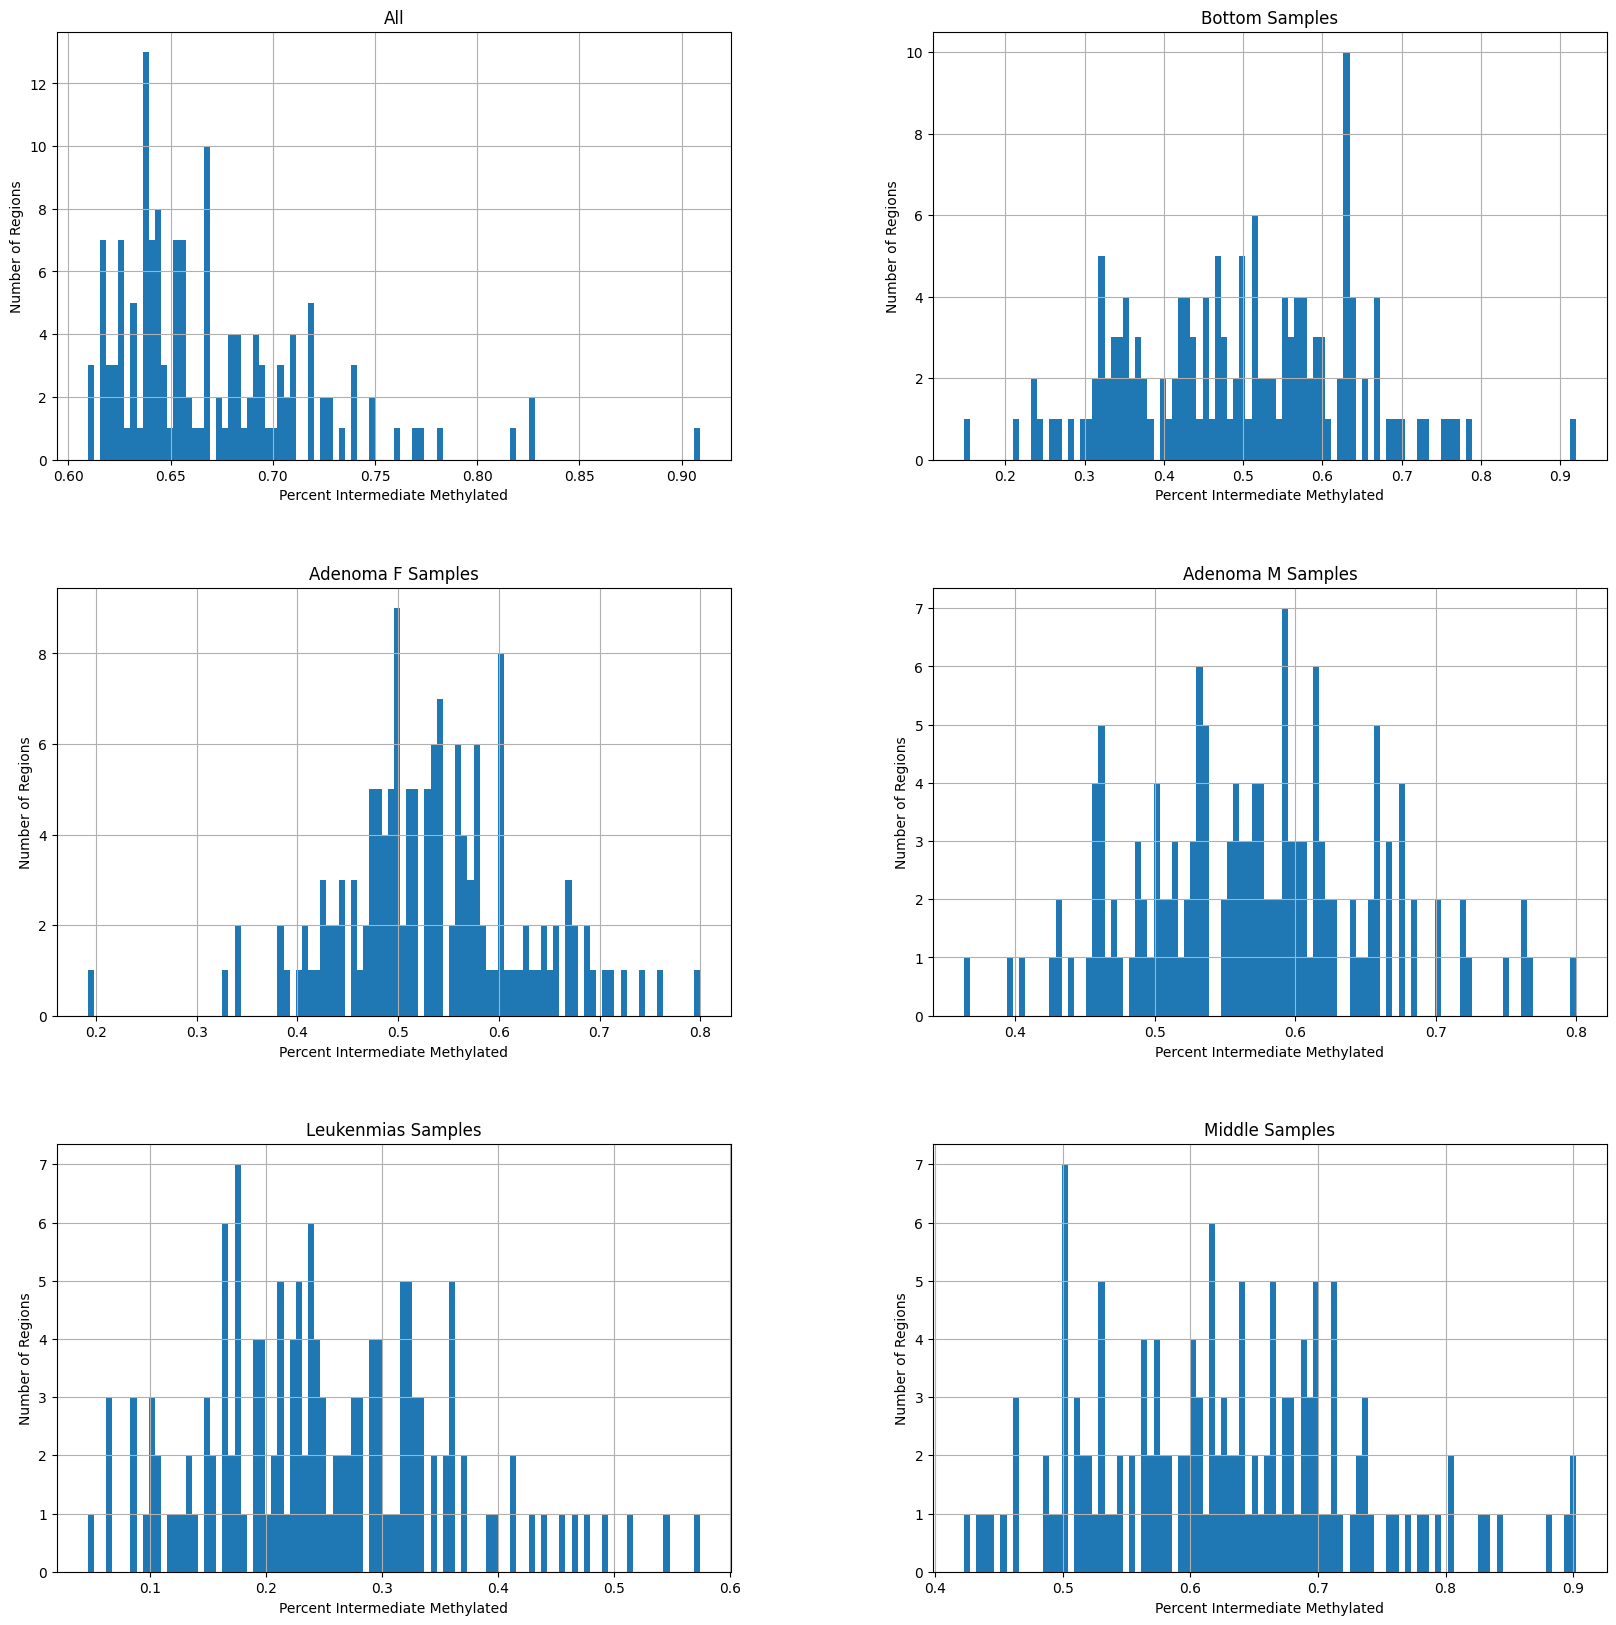

In [28]:
plts = windows_to_analyze[
    ["intermediate_percent_all"]
    + [f"intermediate_percent_{key.lower()}" for key in window_df_dict.keys()]
].hist(bins=100, figsize=(20, 20))
for row in plts:
    for plot in row:
        plot.set_xlabel("Percent Intermediate Methylated")
        plot.set_ylabel("Number of Regions")
        plot.set_title(plot.get_title().replace("intermediate_percent_", "").replace("_", " ").title())

plt.show()